# Vignette 4: Cross-Source Citation Reliability

**Research question**: How much do S2AG vs. OpenAlex citation counts diverge for the same papers? Can we trust any single source?

This analysis joins: S2AG + OpenAlex + SciSciNet citation counts for the same DOIs.

In [1]:
import duckdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Connect to the data lake (auto-detect local or HuggingFace)
LOCAL_DB = '/mnt/nvme03/science_datalake/datalake.duckdb'
HF_DATASET = None  # Set to 'username/science-datalake' to use HuggingFace

import os
if os.path.exists(LOCAL_DB) and not HF_DATASET:
    con = duckdb.connect(LOCAL_DB, read_only=True)
else:
    con = duckdb.connect(':memory:')
    con.execute("INSTALL httpfs; LOAD httpfs;")
    base = f"hf://datasets/{HF_DATASET}"
    con.execute("CREATE SCHEMA IF NOT EXISTS xref")
    con.execute(f"CREATE VIEW xref.unified_papers AS SELECT * FROM read_parquet('{base}/xref/unified_papers/*.parquet')")
    con.execute(f"CREATE VIEW xref.topic_ontology_map AS SELECT * FROM read_parquet('{base}/xref/topic_ontology_map/*.parquet')")
    con.execute("CREATE SCHEMA IF NOT EXISTS openalex")
    con.execute(f"CREATE VIEW openalex.works_topics AS SELECT * FROM read_parquet('{base}/openalex/works_topics/*.parquet')")
    con.execute(f"CREATE VIEW openalex.topics AS SELECT * FROM read_parquet('{base}/openalex/topics/*.parquet')")

con.execute('SET threads=16')

# Papers present in all 3 sources with citation counts
n_all3 = con.execute("""
    SELECT COUNT(*)
    FROM xref.unified_papers
    WHERE has_s2ag AND has_openalex AND has_sciscinet
        AND s2ag_citationcount IS NOT NULL
        AND oa_cited_by_count IS NOT NULL
        AND sciscinet_citation_count IS NOT NULL
""").fetchone()[0]
print(f'Papers with citation counts in all 3 sources: {n_all3:,}')

Papers with citation counts in all 3 sources: 120,990,697


In [2]:
# Summary statistics of citation count differences
df_stats = con.execute("""
    SELECT
        ROUND(corr(s2ag_citationcount, oa_cited_by_count), 4) AS s2ag_oa_corr,
        ROUND(corr(s2ag_citationcount, sciscinet_citation_count), 4) AS s2ag_ssn_corr,
        ROUND(corr(oa_cited_by_count, sciscinet_citation_count), 4) AS oa_ssn_corr,
        ROUND(AVG(ABS(s2ag_citationcount - oa_cited_by_count)), 2) AS avg_abs_diff_s2ag_oa,
        ROUND(AVG(ABS(s2ag_citationcount - sciscinet_citation_count)), 2) AS avg_abs_diff_s2ag_ssn,
        ROUND(AVG(ABS(oa_cited_by_count - sciscinet_citation_count)), 2) AS avg_abs_diff_oa_ssn
    FROM xref.unified_papers
    WHERE has_s2ag AND has_openalex AND has_sciscinet
        AND s2ag_citationcount IS NOT NULL
        AND oa_cited_by_count IS NOT NULL
        AND sciscinet_citation_count IS NOT NULL
""").df()
print('Cross-source citation correlations and mean absolute differences:')
df_stats.T

Cross-source citation correlations and mean absolute differences:


,0
s2ag_oa_corr,0.7599
s2ag_ssn_corr,0.8686
oa_ssn_corr,0.8643
avg_abs_diff_s2ag_oa,4.1400
avg_abs_diff_s2ag_ssn,3.8400
avg_abs_diff_oa_ssn,2.3000


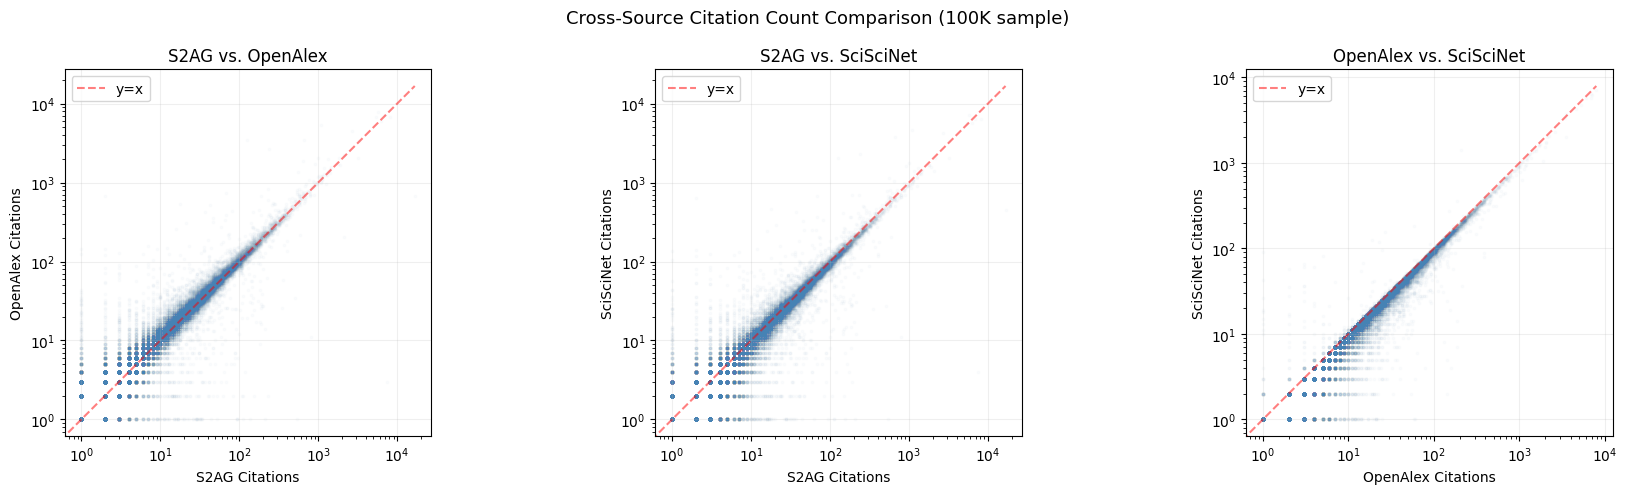

In [3]:
# Scatter plot: S2AG vs OpenAlex citation counts (sample)
df_scatter = con.execute("""
    SELECT
        s2ag_citationcount AS s2ag,
        oa_cited_by_count AS openalex,
        sciscinet_citation_count AS sciscinet,
        year
    FROM xref.unified_papers
    WHERE has_s2ag AND has_openalex AND has_sciscinet
        AND s2ag_citationcount > 0
        AND oa_cited_by_count > 0
    USING SAMPLE 100000
""").df()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = [
    ('s2ag', 'openalex', 'S2AG', 'OpenAlex'),
    ('s2ag', 'sciscinet', 'S2AG', 'SciSciNet'),
    ('openalex', 'sciscinet', 'OpenAlex', 'SciSciNet'),
]

for ax, (x, y, xlabel, ylabel) in zip(axes, pairs):
    ax.scatter(df_scatter[x], df_scatter[y], alpha=0.02, s=3, color='steelblue')
    # Perfect agreement line
    max_val = max(df_scatter[x].max(), df_scatter[y].max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='y=x')
    ax.set_xlabel(f'{xlabel} Citations')
    ax.set_ylabel(f'{ylabel} Citations')
    ax.set_title(f'{xlabel} vs. {ylabel}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal')
    ax.legend()
    ax.grid(True, alpha=0.2)

plt.suptitle('Cross-Source Citation Count Comparison (100K sample)', fontsize=13)
plt.tight_layout()
plt.show()

In [4]:
# Divergence by citation magnitude
df_buckets = con.execute("""
    WITH bucketed AS (
        SELECT
            CASE
                WHEN oa_cited_by_count < 10 THEN '0-9'
                WHEN oa_cited_by_count < 50 THEN '10-49'
                WHEN oa_cited_by_count < 100 THEN '50-99'
                WHEN oa_cited_by_count < 500 THEN '100-499'
                WHEN oa_cited_by_count < 1000 THEN '500-999'
                ELSE '1000+'
            END AS citation_bucket,
            CASE
                WHEN oa_cited_by_count < 10 THEN 1
                WHEN oa_cited_by_count < 50 THEN 2
                WHEN oa_cited_by_count < 100 THEN 3
                WHEN oa_cited_by_count < 500 THEN 4
                WHEN oa_cited_by_count < 1000 THEN 5
                ELSE 6
            END AS bucket_order,
            s2ag_citationcount,
            oa_cited_by_count,
            sciscinet_citation_count
        FROM xref.unified_papers
        WHERE has_s2ag AND has_openalex AND has_sciscinet
            AND s2ag_citationcount IS NOT NULL
            AND oa_cited_by_count IS NOT NULL
            AND sciscinet_citation_count IS NOT NULL
    )
    SELECT
        citation_bucket,
        COUNT(*) AS n_papers,
        ROUND(AVG(ABS(s2ag_citationcount - oa_cited_by_count)), 2) AS avg_abs_diff_s2ag_oa,
        ROUND(AVG(100.0 * ABS(s2ag_citationcount - oa_cited_by_count) /
            GREATEST(s2ag_citationcount, oa_cited_by_count, 1)), 1) AS avg_pct_diff_s2ag_oa,
        ROUND(CORR(s2ag_citationcount, oa_cited_by_count), 4) AS corr_s2ag_oa
    FROM bucketed
    GROUP BY citation_bucket, bucket_order
    ORDER BY bucket_order
""").df()
print('Citation divergence by magnitude:')
df_buckets

Citation divergence by magnitude:


,citation_bucket,n_papers,avg_abs_diff_s2ag_oa,avg_pct_diff_s2ag_oa,corr_s2ag_oa
0,0-9,82277970,1.15,20.2,0.0558
1,10-49,27611357,4.89,18.3,0.2162
2,50-99,6452283,11.32,14.5,0.2515
3,100-499,4289559,28.07,13.5,0.5602
4,500-999,251495,109.71,14.5,0.3834
5,1000+,108033,463.78,17.2,0.7317


In [5]:
# Papers with largest absolute disagreement
df_outliers = con.execute("""
    SELECT
        doi,
        title,
        year,
        s2ag_citationcount AS s2ag,
        oa_cited_by_count AS openalex,
        sciscinet_citation_count AS sciscinet,
        ABS(s2ag_citationcount - oa_cited_by_count) AS abs_diff
    FROM xref.unified_papers
    WHERE has_s2ag AND has_openalex
        AND s2ag_citationcount IS NOT NULL
        AND oa_cited_by_count IS NOT NULL
        AND s2ag_citationcount > 100
    ORDER BY abs_diff DESC
    LIMIT 15
""").df()
print('Papers with largest S2AG-OpenAlex citation count disagreement:')
df_outliers

Papers with largest S2AG-OpenAlex citation count disagreement:


,doi,title,year,s2ag,openalex,sciscinet,abs_diff
0,10.1016/s1084-8045(02)00061-9,Publisher's Note,2003,257887,0,0,257887
1,10.1017/cbo9781139207249.009,I and J,2012,168759,18,18,168741
2,10.5694/j.1326-5377.1954.tb66294.x,THE WORLD HEALTH ORGANIZATION,1954,88975,1,0,88974
3,10.1016/0003-2697(90)90595-z,Molecular cloning: A laboratory manual,1990,503,86156,85135,85653
4,10.1186/s13059-014-0550-8,Moderated estimation of fold change and disper...,2014,9734,93688,70312,83954
5,10.3322/canjclin.39.6.399,Cancer Statistics,1989,80709,3,<NA>,80706
6,10.5555/1953048.2078195,Scikit-learn: Machine Learning in Python,2011,83281,7952,3088,75329
7,10.18653/v1/n19-1423,,2019,105769,30979,30580,74790
8,10.5130/pc.v1i1.976,引言 (Introduction),2009,73729,0,0,73729
9,10.1136/ebmh.11.4.102,<i>Et al</i>,2008,73516,3,3,73513


## Citation Agreement by Ontology-Enriched Field

Using the embedding-based ontology linkage, we ask whether **cross-source citation agreement varies systematically across research disciplines**. For each OpenAlex field (mapped through `topic_ontology_map`), we compute the S2AG-OpenAlex correlation and average percentage difference.

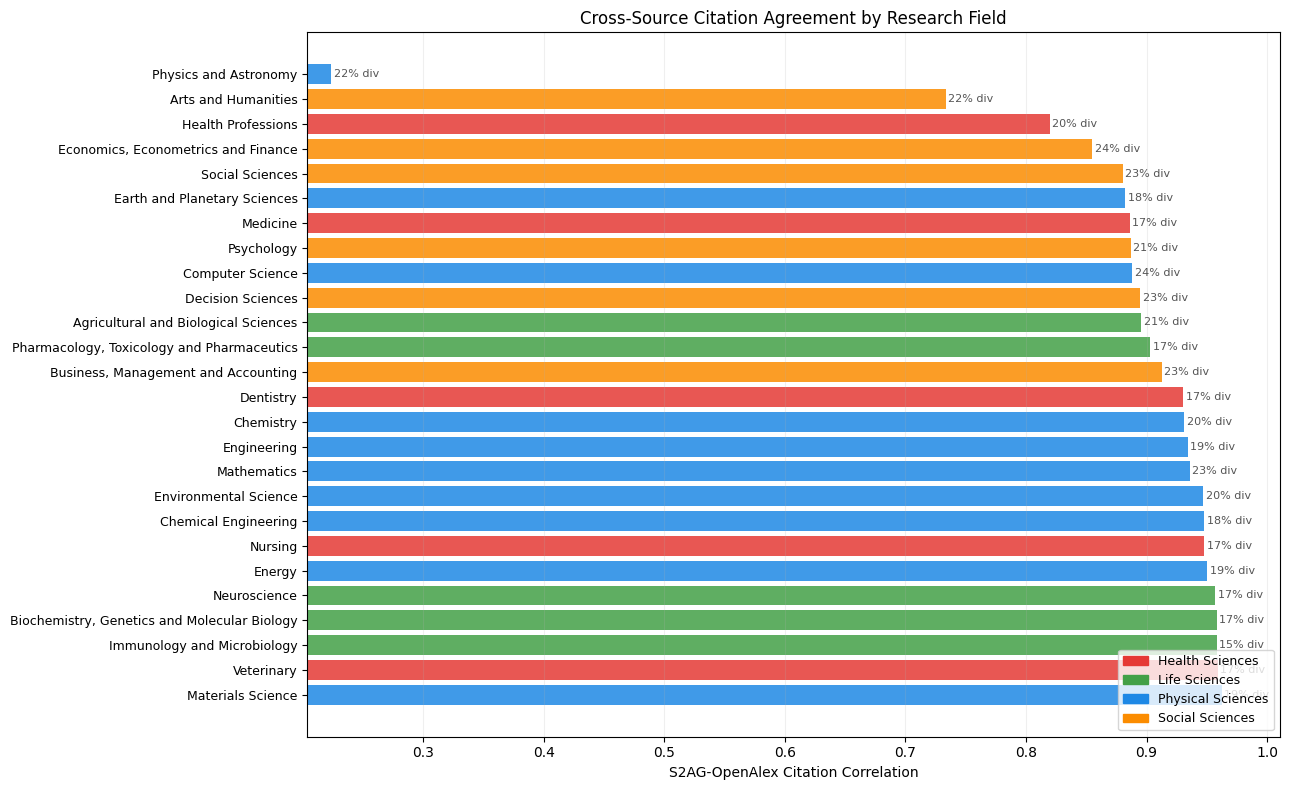

In [6]:
# S2AG-OpenAlex citation correlation and divergence by OpenAlex field
df_field_corr = con.execute("""
    WITH paper_fields AS (
        SELECT
            u.s2ag_citationcount,
            u.oa_cited_by_count,
            m.field,
            m.domain
        FROM xref.unified_papers u
        JOIN openalex.works_topics wt ON wt.work_id = u.openalex_id
        JOIN xref.topic_ontology_map m ON m.topic_id = wt.topic_id
        WHERE u.has_s2ag AND u.has_openalex
            AND u.s2ag_citationcount IS NOT NULL
            AND u.oa_cited_by_count IS NOT NULL
            AND wt.score >= 0.5
            AND m.similarity >= 0.85
    )
    SELECT
        field,
        domain,
        COUNT(*) AS n_papers,
        ROUND(CORR(s2ag_citationcount, oa_cited_by_count), 4) AS s2ag_oa_corr,
        ROUND(AVG(100.0 * ABS(s2ag_citationcount - oa_cited_by_count)
            / GREATEST(s2ag_citationcount, oa_cited_by_count, 1)), 1) AS avg_pct_diff
    FROM paper_fields
    GROUP BY field, domain
    HAVING COUNT(*) >= 1000
    ORDER BY s2ag_oa_corr ASC
""").df()

domain_colors = {
    'Health Sciences': '#E53935',
    'Life Sciences': '#43A047',
    'Physical Sciences': '#1E88E5',
    'Social Sciences': '#FB8C00',
}

fig, ax = plt.subplots(figsize=(13, 8))
colors = [domain_colors.get(d, '#757575') for d in df_field_corr['domain']]
bars = ax.barh(range(len(df_field_corr)), df_field_corr['s2ag_oa_corr'],
               color=colors, alpha=0.85)
ax.set_yticks(range(len(df_field_corr)))
ax.set_yticklabels(df_field_corr['field'], fontsize=9)
ax.set_xlabel('S2AG-OpenAlex Citation Correlation')
ax.set_title('Cross-Source Citation Agreement by Research Field')

# Annotate with % divergence
for i, (_, row) in enumerate(df_field_corr.iterrows()):
    ax.text(row['s2ag_oa_corr'] + 0.002, i,
            f"{row['avg_pct_diff']:.0f}% div",
            va='center', fontsize=8, color='#555')

# Domain legend
from matplotlib.patches import Patch
legend_patches = [Patch(color=c, label=d) for d, c in domain_colors.items()]
ax.legend(handles=legend_patches, loc='lower right', fontsize=9)

ax.invert_yaxis()
ax.grid(True, axis='x', alpha=0.2)
ax.set_xlim(left=min(df_field_corr['s2ag_oa_corr']) - 0.02)
plt.tight_layout()
plt.show()

## Key Findings

1. **Cross-source citation correlations are high** but not perfect
2. **Percentage divergence is larger for low-cited papers** and smaller for highly-cited ones
3. **Outlier papers show systematic differences** in source coverage
4. **No single citation count is "ground truth"** — the unified view enables researchers to choose or aggregate
5. **Citation agreement varies by research discipline** — ontology-enriched field mapping reveals systematic cross-source divergence patterns, with some domains showing consistently higher S2AG-OpenAlex disagreement than others

This is the first large-scale comparison of citation counts across S2AG, OpenAlex, and SciSciNet simultaneously.